<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 80

# Student 1:

# Student 2: Tobias Sagis - 1333151

# Student 3:

# Downloading Data and Preliminaries

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch import nn

from zipfile import ZipFile
import requests
import io

C:\Users\Tobias\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [4]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [5]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [6]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [7]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

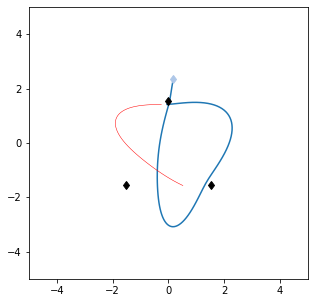

Charges are [-0.44760574 -0.91493189 -0.844136  ]


In [8]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [9]:
#todo

## Model Implementation

In [10]:
#todo

## Model Training

In [11]:
#todo

## Evaluation

In [12]:
#todo

# Task 3.2

## Data Handling and Preprocessing

In [13]:
def get_particle_tensor_initial_trajectory(sim_id, t):
    if torch.cuda.is_available():
        return torch.tensor(simulation_train_task32[sim_id][t]).type(torch.FloatTensor).cuda()
    else:
        return torch.tensor(simulation_train_task32[sim_id][t]).type(torch.FloatTensor)

def get_particle_tensor_continuation_trajectory(sim_id, t):
    if torch.cuda.is_available():
        return torch.tensor(simulation_continued_train[sim_id][t]).type(torch.FloatTensor).cuda()
    else:
        return torch.tensor(simulation_continued_train[sim_id][t]).type(torch.FloatTensor)

def get_particle_tensor_initial_trajectory_val(sim_id, t):
    if torch.cuda.is_available():
        return torch.tensor(simulation_valid[sim_id][t]).type(torch.FloatTensor).cuda()
    else:
        return torch.tensor(simulation_valid[sim_id][t]).type(torch.FloatTensor)

def get_particle_tensor_continuation_trajectory_val(sim_id, t):
    if torch.cuda.is_available():
        return torch.tensor(simulation_continued_valid[sim_id][t]).type(torch.FloatTensor).cuda()
    else:
        return torch.tensor(simulation_continued_valid[sim_id][t]).type(torch.FloatTensor)
    
def get_particle_tensor_initial_trajectory_test(sim_id, t):
    if torch.cuda.is_available():
        return torch.tensor(simulation_test[sim_id][t]).type(torch.FloatTensor).cuda()
    else:
        return torch.tensor(simulation_test[sim_id][t]).type(torch.FloatTensor)

def get_particle_tensor_continuation_trajectory_test(sim_id, t):
    if torch.cuda.is_available():
        return torch.tensor(simulation_continued_test[sim_id][t]).type(torch.FloatTensor).cuda()
    else:
        return torch.tensor(simulation_continued_test[sim_id][t]).type(torch.FloatTensor)

(103, 2)
tensor([-2.3341,  0.2843], dtype=torch.float64)
(54, 2)


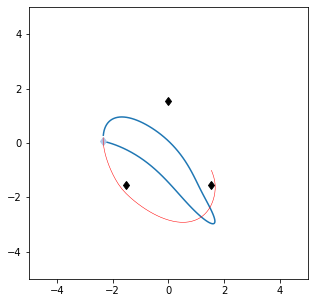

In [14]:
print(simulation_train_task32[0].shape)
print(torch.tensor(simulation_train_task32[0][102]))
print(simulation_continued_train[0].shape)
plot_example(simulation_train_task32[0], simulation_continued_train[0])

## Model Implementation

In [55]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, num_layers=20)
        
        # Two fully connected layers to output 
        self.fc =  nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, inputs):
        # Initialize h_0 and c_0
        h_0 = torch.randn(20, hidden_dim).type(torch.FloatTensor).cuda()
        c_0 = torch.randn(20, hidden_dim).type(torch.FloatTensor).cuda()
        
        # Forward propagate
        out, (h_n, c_n) = self.lstm(inputs, (h_0, c_0))
        #print("1")
        #print(h_n.shape)
        
        # Reshape before forwarding
        output = h_n.view(-1, self.hidden_dim)
        #print("2")
        #print(output.shape)
        
        # Forward through dense layers
        output = self.fc(output)
        #print("3")
        #print(output.shape)
        return output

## Model Training

In [60]:
# User-defined hyperparameters
input_dim = 2
hidden_dim = 2
lstm = LSTM(input_dim, hidden_dim).cuda()

# Training the model
criterion = nn.MSELoss() # Due to being a regression-like problem we use mean squared error
learning_rate = 0.1
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

# Number of epochs to train for
epochs = 10

# Store average loss and std for each epoch
lossPerEpoch = np.empty((epochs, 1))
stdPerEpoch = np.empty((epochs, 1))

for epoch in range(epochs):
    total_loss = 0
    differences = 0

    # Set in train mode
    lstm.train()
    
    # Train the model
    for i in range(150):
        # Get the initial trajectory
        initial_trajectory = get_particle_tensor_initial_trajectory(i, range(90))
        
        # Feed-forward it through the network
        predicted_continuation_trajectory = lstm(initial_trajectory)
        #print("4")
        #print(predicted_continuation_trajectory.shape)
        #print("5")
        #print(get_particle_tensor_continuation_trajectory(i, range(20)).shape)
        # Compute loss
        loss = criterion(predicted_continuation_trajectory, get_particle_tensor_continuation_trajectory(i, range(20)))

        # Backward propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / 150
    
    print('Epoch:', epoch, '\tLoss:', average_loss)

Epoch: 0 	Loss: 3.28145169566075
Epoch: 1 	Loss: 3.2730570298433306
Epoch: 2 	Loss: 3.2699346458911895
Epoch: 3 	Loss: 3.268417522907257
Epoch: 4 	Loss: 3.2669129466017086
Epoch: 5 	Loss: 3.2652461943030358
Epoch: 6 	Loss: 3.2633795002102852
Epoch: 7 	Loss: 3.261318841377894
Epoch: 8 	Loss: 3.259009700814883
Epoch: 9 	Loss: 3.256245457927386


In [53]:
y = get_particle_tensor_continuation_trajectory(i, range(20))
print(y.shape)
print(predicted_continuation_trajectory.shape)
print(get_particle_tensor_continuation_trajectory(i, range(20)).shape)

torch.Size([20, 2])
torch.Size([20, 2])
torch.Size([20, 2])


## Evaluation

In [ ]:
#todo